In [1]:
import pandas as pd
import numpy as np
import datetime as dt
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x: '%.5f' % x)

df_ = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")
df_.head()

Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate   Price  Customer ID         Country  
0 2010-12-01 08:26:00 2.55000  17850.00000  United Kingdom  
1 2010-12-01 08:26:00 3.39000  17850.00000  United Kingdom  
2 2010-12-01 08:26:00 2.75000  17850.00000  United Kingdom  
3 2010-12-01 08:26:00 3.39000  17850.00000  United Kingdom  
4 2010-12-01 08:26:00 3.39000  17850.00000  United Kingdom

In [198]:
df = df_.copy()
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C",na=False)]
df = df[df["Quantity"]>0]
df = df[df["Price"]>0]


def find_limits(df,variable):
    q1 = df[variable].quantile(0.01)
    q3 = df[variable].quantile(0.99)
    iqr = q3 - q1
    upper_limit = q3 + 1.5*iqr
    lower_limit = q1 - 1.5*iqr
    df[variable].clip(upper=upper_limit,inplace=True)
    
find_limits(df,"Quantity")
find_limits(df,"Price")
df["total_price"] = df["Quantity"] * df["Price"]

In [199]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data as summary

In [200]:
cltv_df=summary(df,"Customer ID","InvoiceDate","total_price",
        observation_period_end="2011-12-11",
        freq="W")
cltv_df

frequency  recency        T  monetary_value
Customer ID                                             
12346.00000    0.00000  0.00000 46.00000         0.00000
12347.00000    6.00000 52.00000 52.00000       599.70167
12348.00000    3.00000 40.00000 51.00000       298.54000
12349.00000    0.00000  0.00000  2.00000         0.00000
12350.00000    0.00000  0.00000 44.00000         0.00000
...                ...      ...      ...             ...
18280.00000    0.00000  0.00000 39.00000         0.00000
18281.00000    0.00000  0.00000 26.00000         0.00000
18282.00000    1.00000 17.00000 18.00000        77.84000
18283.00000   13.00000 48.00000 48.00000       152.80231
18287.00000    2.00000 23.00000 29.00000       536.00000

[4338 rows x 4 columns]

In [201]:
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(frequency=cltv_df["frequency"],
        recency=cltv_df["recency"],
        T=cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 7.78, b: 0.00, r: 0.62>

In [202]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df["frequency"],
                                                        cltv_df["recency"],
                                                        cltv_df["T"]).sort_values(ascending =False).head(10)

Customer ID
14606.00000   0.86569
17841.00000   0.84924
14527.00000   0.81634
15311.00000   0.79989
14911.00000   0.78343
12748.00000   0.75053
12971.00000   0.75053
13089.00000   0.70117
15039.00000   0.69618
16422.00000   0.68472
dtype: float64

In [203]:
cltv_df["expected_puch_1_week"] = bgf.predict(1,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

In [204]:
cltv_df["expected_puch_1_month"] =bgf.predict(4,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

In [205]:
bgf.predict(4,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sum()

1372.3456265214395

In [206]:
cltv_df

frequency  recency        T  monetary_value  \
Customer ID                                                
12346.00000    0.00000  0.00000 46.00000         0.00000   
12347.00000    6.00000 52.00000 52.00000       599.70167   
12348.00000    3.00000 40.00000 51.00000       298.54000   
12349.00000    0.00000  0.00000  2.00000         0.00000   
12350.00000    0.00000  0.00000 44.00000         0.00000   
...                ...      ...      ...             ...   
18280.00000    0.00000  0.00000 39.00000         0.00000   
18281.00000    0.00000  0.00000 26.00000         0.00000   
18282.00000    1.00000 17.00000 18.00000        77.84000   
18283.00000   13.00000 48.00000 48.00000       152.80231   
18287.00000    2.00000 23.00000 29.00000       536.00000   

             expected_puch_1_week  expected_puch_1_month  
Customer ID                                               
12346.00000               0.01153                0.04610  
12347.00000               0.11073                0.44292  
12348.00000               0.06158                0.24632  
12349.00000               0.06336                0.25345  
12350.00000               0.01197                0.04788  
...                           ...                    ...  
18280.00000               0.01325                0.05300  
18281.00000               0.01835                0.07340  
18282.00000               0.06283                0.25131  
18283.00000               0.24416                0.97662  
18287.00000               0.07122                0.28490  

[4338 rows x 6 columns]

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

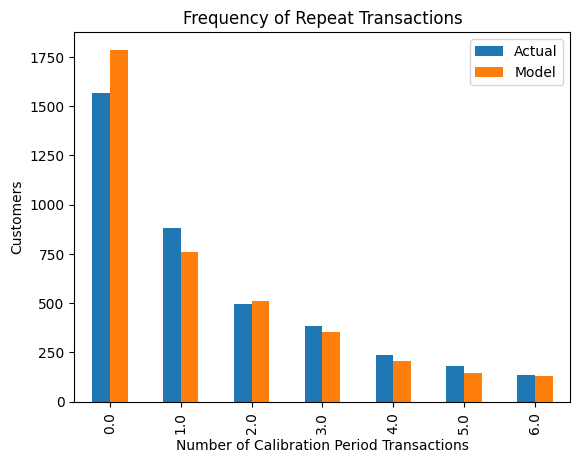

In [207]:
plot_period_transactions(bgf)

In [209]:
returning = cltv_df[cltv_df["frequency"]>0]
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(returning["frequency"],returning["monetary_value"]) 

<lifetimes.GammaGammaFitter: fitted with 2772 subjects, p: 2.19, q: 3.63, v: 496.82>

In [210]:
ggf.conditional_expected_average_profit(returning["frequency"],
                                        returning["monetary_value"]).sort_values(ascending = False)

Customer ID
18102.00000   10158.74242
14646.00000    8544.95079
12415.00000    8016.68660
17450.00000    6161.54527
16684.00000    4194.94747
                  ...    
16668.00000     121.38849
14560.00000     121.15880
15581.00000     103.64157
18037.00000      86.35787
17961.00000      55.94654
Length: 2772, dtype: float64

In [211]:
ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                        cltv_df["monetary_value"])

Customer ID
12346.00000   413.52547
12347.00000   568.64147
12348.00000   331.42097
12349.00000   413.52547
12350.00000   413.52547
                 ...   
18280.00000   413.52547
18281.00000   413.52547
18282.00000   261.04036
18283.00000   174.85930
18287.00000   490.03783
Length: 4338, dtype: float64

In [212]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                        cltv_df["monetary_value"])

In [213]:
cltv_df.sort_values(by="expected_average_profit",ascending=False)

frequency  recency        T  monetary_value  \
Customer ID                                                
18102.00000   20.00000 52.00000 52.00000     10744.15275   
14646.00000   29.00000 50.00000 50.00000      8881.82483   
12415.00000   13.00000 45.00000 48.00000      8719.35385   
17450.00000   20.00000 51.00000 52.00000      6506.83775   
16684.00000   13.00000 51.00000 51.00000      4544.41808   
...                ...      ...      ...             ...   
16668.00000    5.00000 38.00000 40.00000        51.19200   
14560.00000   18.00000 50.00000 51.00000       101.64444   
15581.00000    9.00000 35.00000 52.00000        62.27444   
18037.00000    5.00000 30.00000 52.00000         7.74400   
17961.00000   27.00000 50.00000 53.00000        40.03519   

             expected_puch_1_week  expected_puch_1_month  \
Customer ID                                                
18102.00000               0.34491                1.37964   
14646.00000               0.51260                2.05040   
12415.00000               0.24416                0.97662   
17450.00000               0.34491                1.37964   
16684.00000               0.23170                0.92678   
...                           ...                    ...   
16668.00000               0.11761                0.47045   
14560.00000               0.31675                1.26701   
15581.00000               0.16091                0.64365   
18037.00000               0.09400                0.37602   
17961.00000               0.45440                1.81759   

             expected_average_profit  
Customer ID                           
18102.00000              10158.74242  
14646.00000               8544.95079  
12415.00000               8016.68660  
17450.00000               6161.54527  
16684.00000               4194.94747  
...                              ...  
16668.00000                121.38849  
14560.00000                121.15880  
15581.00000                103.64157  
18037.00000                 86.35787  
17961.00000                 55.94654  

[4338 rows x 7 columns]

In [214]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary_value"],
                                   time=3, #monthly
                                   freq="W",#freq of T
                                   discount_rate=0.01)

C:\Users\oskar\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [215]:
cltv

Customer ID
12346.00000    60.90611
12347.00000   804.62046
12348.00000   260.79777
12349.00000   334.82121
12350.00000    63.25844
                 ...   
18280.00000    70.01920
18281.00000    96.96275
18282.00000   209.57375
18283.00000   545.55574
18287.00000   446.00935
Name: clv, Length: 4338, dtype: float64

In [216]:
cltv_final = pd.merge(cltv_df,cltv,right_index=True,left_index=True)
cltv_final

frequency  recency        T  monetary_value  \
Customer ID                                                
12346.00000    0.00000  0.00000 46.00000         0.00000   
12347.00000    6.00000 52.00000 52.00000       599.70167   
12348.00000    3.00000 40.00000 51.00000       298.54000   
12349.00000    0.00000  0.00000  2.00000         0.00000   
12350.00000    0.00000  0.00000 44.00000         0.00000   
...                ...      ...      ...             ...   
18280.00000    0.00000  0.00000 39.00000         0.00000   
18281.00000    0.00000  0.00000 26.00000         0.00000   
18282.00000    1.00000 17.00000 18.00000        77.84000   
18283.00000   13.00000 48.00000 48.00000       152.80231   
18287.00000    2.00000 23.00000 29.00000       536.00000   

             expected_puch_1_week  expected_puch_1_month  \
Customer ID                                                
12346.00000               0.01153                0.04610   
12347.00000               0.11073                0.44292   
12348.00000               0.06158                0.24632   
12349.00000               0.06336                0.25345   
12350.00000               0.01197                0.04788   
...                           ...                    ...   
18280.00000               0.01325                0.05300   
18281.00000               0.01835                0.07340   
18282.00000               0.06283                0.25131   
18283.00000               0.24416                0.97662   
18287.00000               0.07122                0.28490   

             expected_average_profit       clv  
Customer ID                                     
12346.00000                413.52547  60.90611  
12347.00000                568.64147 804.62046  
12348.00000                331.42097 260.79777  
12349.00000                413.52547 334.82121  
12350.00000                413.52547  63.25844  
...                              ...       ...  
18280.00000                413.52547  70.01920  
18281.00000                413.52547  96.96275  
18282.00000                261.04036 209.57375  
18283.00000                174.85930 545.55574  
18287.00000                490.03783 446.00935  

[4338 rows x 8 columns]

In [217]:
cltv_final.sort_values(by="clv",ascending=False).head(10)

frequency  recency        T  monetary_value  \
Customer ID                                                
14646.00000   29.00000 50.00000 50.00000      8881.82483   
18102.00000   20.00000 52.00000 52.00000     10744.15275   
14096.00000   14.00000 14.00000 14.00000      3832.56714   
14911.00000   47.00000 53.00000 53.00000      2909.85404   
17450.00000   20.00000 51.00000 52.00000      6506.83775   
12415.00000   13.00000 45.00000 48.00000      8719.35385   
14156.00000   30.00000 52.00000 53.00000      3852.73033   
17511.00000   25.00000 53.00000 53.00000      3565.05980   
13694.00000   28.00000 53.00000 53.00000      2250.54518   
15311.00000   48.00000 53.00000 53.00000      1243.06833   

             expected_puch_1_week  expected_puch_1_month  \
Customer ID                                                
14646.00000               0.51260                2.05040   
18102.00000               0.34491                1.37964   
14096.00000               0.67114                2.68457   
14911.00000               0.78343                3.13374   
17450.00000               0.34491                1.37964   
12415.00000               0.24416                0.97662   
14156.00000               0.50375                2.01501   
17511.00000               0.42149                1.68598   
13694.00000               0.47085                1.88340   
15311.00000               0.79989                3.19954   

             expected_average_profit         clv  
Customer ID                                       
14646.00000               8544.95079 55972.08088  
18102.00000              10158.74242 44774.15155  
14096.00000               3562.34634 30551.61574  
14911.00000               2847.63251 28508.13833  
17450.00000               6161.54527 27156.70406  
12415.00000               8016.68660 25011.81956  
14156.00000               3720.30155 23948.50322  
17511.00000               3420.55047 18423.40558  
13694.00000               2174.96489 13086.29881  
15311.00000               1222.81204 12498.85420

In [218]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"],4,labels=["D","C","B","A"])

In [219]:
cltv_final

frequency  recency        T  monetary_value  \
Customer ID                                                
12346.00000    0.00000  0.00000 46.00000         0.00000   
12347.00000    6.00000 52.00000 52.00000       599.70167   
12348.00000    3.00000 40.00000 51.00000       298.54000   
12349.00000    0.00000  0.00000  2.00000         0.00000   
12350.00000    0.00000  0.00000 44.00000         0.00000   
...                ...      ...      ...             ...   
18280.00000    0.00000  0.00000 39.00000         0.00000   
18281.00000    0.00000  0.00000 26.00000         0.00000   
18282.00000    1.00000 17.00000 18.00000        77.84000   
18283.00000   13.00000 48.00000 48.00000       152.80231   
18287.00000    2.00000 23.00000 29.00000       536.00000   

             expected_puch_1_week  expected_puch_1_month  \
Customer ID                                                
12346.00000               0.01153                0.04610   
12347.00000               0.11073                0.44292   
12348.00000               0.06158                0.24632   
12349.00000               0.06336                0.25345   
12350.00000               0.01197                0.04788   
...                           ...                    ...   
18280.00000               0.01325                0.05300   
18281.00000               0.01835                0.07340   
18282.00000               0.06283                0.25131   
18283.00000               0.24416                0.97662   
18287.00000               0.07122                0.28490   

             expected_average_profit       clv segment  
Customer ID                                             
12346.00000                413.52547  60.90611       D  
12347.00000                568.64147 804.62046       A  
12348.00000                331.42097 260.79777       B  
12349.00000                413.52547 334.82121       B  
12350.00000                413.52547  63.25844       D  
...                              ...       ...     ...  
18280.00000                413.52547  70.01920       D  
18281.00000                413.52547  96.96275       D  
18282.00000                261.04036 209.57375       C  
18283.00000                174.85930 545.55574       A  
18287.00000                490.03783 446.00935       B  

[4338 rows x 9 columns]

In [221]:
cltv_final.groupby("segment").agg(["mean","sum"])

frequency             recency                    T              \
             mean        sum     mean         sum     mean         sum   
segment                                                                  
D         0.25417  274.00000  5.76160  6211.00000 37.71707 40659.00000   
C         1.10297 1189.00000 16.20037 17464.00000 27.58071 29732.00000   
B         2.12894 2295.00000 20.32189 21907.00000 25.89703 27917.00000   
A         7.26160 7828.00000 32.91466 35482.00000 36.07514 38889.00000   

        monetary_value              expected_puch_1_week            \
                  mean          sum                 mean       sum   
segment                                                              
D             34.29493  36969.93150              0.01930  20.80908   
C            154.01001 166022.79002              0.04599  49.57412   
B            248.16905 267526.23147              0.07751  83.55083   
A            617.49802 665662.86918              0.17355 187.08167   

        expected_puch_1_month           expected_average_profit               \
                         mean       sum                    mean          sum   
segment                                                                        
D                     0.07721  83.23632               386.03662 416147.47738   
C                     0.18395 198.29647               353.51877 381093.23692   
B                     0.31002 334.20333               369.48316 398302.84683   
A                     0.69418 748.32667               571.93257 616543.31259   

               clv                
              mean           sum  
segment                           
D         89.43197   96407.65900  
C        193.58099  208680.31029  
B        334.91185  361034.96969  
A       1349.36795 1454618.65514

In [222]:
df = df_.copy()

def create_cltv(df,month=3):
    #data prep
    df.dropna(inplace=True)
    df = df[~df["Invoice"].str.contains("C",na=False)]
    df = df[df["Quantity"]>0]
    df = df[df["Price"]>0]


    def find_limits(df,variable):
        q1 = df[variable].quantile(0.01)
        q3 = df[variable].quantile(0.99)
        iqr = q3 - q1
        upper_limit = q3 + 1.5*iqr
        lower_limit = q1 - 1.5*iqr
        df[variable].clip(upper=upper_limit,inplace=True)
        
    find_limits(df,"Quantity")
    find_limits(df,"Price")
    df["total_price"] = df["Quantity"] * df["Price"]
    
    cltv_df=summary(df,"Customer ID","InvoiceDate","total_price",
        observation_period_end="2011-12-11",
        freq="W")
    
    # BG-NBD
    bgf = BetaGeoFitter(penalizer_coef=0.1)
    bgf.fit(frequency=cltv_df["frequency"],
        recency=cltv_df["recency"],
        T=cltv_df["T"])
    cltv_df["expected_puch_1_week"] = bgf.predict(1,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])
    
    cltv_df["expected_puch_1_month"] =bgf.predict(4,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])
    
    # Gamma Gamma
    returning = cltv_df[cltv_df["frequency"]>0]
    ggf = GammaGammaFitter(penalizer_coef=0)
    ggf.fit(returning["frequency"],returning["monetary_value"]) 
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                        cltv_df["monetary_value"])
    
    #final
    cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary_value"],
                                   time=month, #monthly
                                   freq="W",#freq of T
                                   discount_rate=0.01)
    
    cltv_final = pd.merge(cltv_df,cltv,right_index=True,left_index=True)
    cltv_final["segment"] = pd.qcut(cltv_final["clv"],4,labels=["D","C","B","A"])
    
    return cltv_final

create_cltv(df)

C:\Users\oskar\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


frequency  recency        T  monetary_value  \
Customer ID                                                
12346.00000    0.00000  0.00000 46.00000         0.00000   
12347.00000    6.00000 52.00000 52.00000       599.70167   
12348.00000    3.00000 40.00000 51.00000       298.54000   
12349.00000    0.00000  0.00000  2.00000         0.00000   
12350.00000    0.00000  0.00000 44.00000         0.00000   
...                ...      ...      ...             ...   
18280.00000    0.00000  0.00000 39.00000         0.00000   
18281.00000    0.00000  0.00000 26.00000         0.00000   
18282.00000    1.00000 17.00000 18.00000        77.84000   
18283.00000   13.00000 48.00000 48.00000       152.80231   
18287.00000    2.00000 23.00000 29.00000       536.00000   

             expected_puch_1_week  expected_puch_1_month  \
Customer ID                                                
12346.00000               0.01153                0.04610   
12347.00000               0.11073                0.44292   
12348.00000               0.06158                0.24632   
12349.00000               0.06336                0.25345   
12350.00000               0.01197                0.04788   
...                           ...                    ...   
18280.00000               0.01325                0.05300   
18281.00000               0.01835                0.07340   
18282.00000               0.06283                0.25131   
18283.00000               0.24416                0.97662   
18287.00000               0.07122                0.28490   

             expected_average_profit       clv segment  
Customer ID                                             
12346.00000                413.52547  60.90611       D  
12347.00000                568.64147 804.62046       A  
12348.00000                331.42097 260.79777       B  
12349.00000                413.52547 334.82121       B  
12350.00000                413.52547  63.25844       D  
...                              ...       ...     ...  
18280.00000                413.52547  70.01920       D  
18281.00000                413.52547  96.96275       D  
18282.00000                261.04036 209.57375       C  
18283.00000                174.85930 545.55574       A  
18287.00000                490.03783 446.00935       B  

[4338 rows x 9 columns]